# 00 - Preparation

In [76]:
import warnings
warnings.filterwarnings('ignore')

Define Output Directory

In [77]:
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/supplementary_interaction_t_maps'

# 01 - Imports

**A) Import Niftis from Folders**

**Import The First Matrix**

Enter Folder or CSV Containing Files

In [12]:
# Path to folder or CSV with files. 
import_path = r'/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/derivatives/fourth_level/response_topology/voxelwise_glm/stim_by_age/t_values_interaction/regression_map/t_statistic'
# Ff Importing a CSV
file_pattern = r'*.nii'
# If Importing a Folder
file_column = ''

Run Import

In [13]:
from calvin_utils.file_utils.import_functions import GiiNiiFileImport
matrix_df1 = GiiNiiFileImport(import_path=import_path, file_column=file_column, file_pattern=file_pattern).run()
matrix_df1

Attempting to import from: /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/derivatives/fourth_level/response_topology/voxelwise_glm/stim_by_age/t_values_interaction/regression_map/t_statistic/*.nii


,parkinson_disease_interaction.nii
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
902624,0.0
902625,0.0
902626,0.0
902627,0.0


**Optional: Import Additional Matrices Second Matrix**

Enter Information Relating to the Path of the First Set of Niftis

In [14]:
# Path to folder or CSV with files. 
import_path = r'/Users/cu135/Dropbox (Partners HealthCare)/resources/published_networks/niftis/'
# Ff Importing a CSV
file_pattern = r'Memory Network T Conn.nii*'
# If Importing a Folder
file_column = ''

Import

In [15]:
from calvin_utils.file_utils.import_functions import GiiNiiFileImport
matrix_df2 = GiiNiiFileImport(import_path=import_path, file_column=file_column, file_pattern=file_pattern).run()
matrix_df2

Attempting to import from: /Users/cu135/Dropbox (Partners HealthCare)/resources/published_networks/niftis//Memory Network T Conn.nii*


,Memory Network T Conn.nii
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
902624,0.0
902625,0.0
902626,0.0
902627,0.0


Merge Dataframes

In [16]:
from calvin_utils.nifti_utils.matrix_utilities import join_dataframes
try:
    merged_df = join_dataframes(matrix_df1, matrix_df2)
except:
    print('Matrix DF2 does not exist. Just using DF1')
    merged_df = matrix_df1
merged_df

df1 len:  902629  matrix_df2 len:  902629
Nonzero values in last column:  292019


,parkinson_disease_interaction.nii,Memory Network T Conn.nii
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
902624,0.0,0.0
902625,0.0,0.0
902626,0.0,0.0
902627,0.0,0.0


# 02 - Masking

In [17]:
import numpy as np
from nimlab import datasets as nimds
from nilearn import image

def apply_mask_to_dataframe(merged_df, mask_path=None):
    """
    Apply a mask to a dataframe using either a provided mask or the default MNI ICBM152 mask.
    
    Parameters:
    - merged_df (DataFrame): The dataframe to which the mask should be applied.
    - mask_path (str, optional): The path to the mask image. If not provided, the MNI ICBM152 mask will be used.
    
    Returns:
    - DataFrame: The masked dataframe containing only the rows specified by the mask.
    
    Example usage:
    >>> masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
    """
    
    # Load the mask data based on the provided mask_path or use default mask
    if mask_path is not None:
        brain_indices = np.where(image.load_img(mask_path).get_fdata().flatten() > 0)[0]
    else:
        mni_mask = nimds.get_img("mni_icbm152")
        mask_data = mni_mask.get_fdata().flatten()
        brain_indices = np.where(mask_data > 0)[0]
    
    # Apply the mask to the dataframe
    masked_df = merged_df.iloc[brain_indices]
    
    return masked_df




In [18]:
masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
masked_df


,parkinson_disease_interaction.nii,Memory Network T Conn.nii
93491,1.346053,7.034553
93492,1.514402,4.939664
93493,1.591010,1.760241
93582,1.347226,7.857507
93583,1.414933,5.583203
...,...,...
798193,1.091347,27.091604
798281,0.713016,27.270569
798282,0.812782,28.221195
798283,0.946431,28.994501


Transform the Data

In [19]:
# masked_df = masked_df.abs()
# masked_df[masked_df < 3] = 0 
# masked_df.max()



Sort The Dataframe

In [20]:
from natsort import natsorted
masked_df = masked_df.reindex(columns=natsorted(masked_df.columns))

# 03 - Spatial Correlation

**Perform Correlation**

method_choices:
- 0 = pearson
- 1 = spearman
- 2 = kendall

Only_compare_nonzero_voxels:
- We have already removed brain-external values by masking
- This will simply prevent comparison of voxels that are not present in both maps.

In [21]:
method_choice = 0
only_compare_nonzero_voxels=False

In [22]:
import pandas as pd
from tqdm import tqdm
from natsort import natsorted

def compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=False):
    """
    Compute correlations among columns of a DataFrame using a specified method.
    When only_compare_nonzero_voxels is True, only pairs of non-zero voxels are used for the computation.
    
    Parameters:
    - df (DataFrame): The dataframe for which correlations should be computed.
    - method_choice (int, optional): An integer indicating the correlation method to be used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    - only_compare_nonzero_voxels (bool, optional): Flag to determine whether to compute correlations 
                                                    considering only non-zero voxels. Default is False.
    
    Returns:
    - DataFrame: The correlation matrix.
    
    Example usage:
    >>> corr_matrix = compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=True)
    """
    
    methods = ['pearson', 'spearman', 'kendall']
    method = methods[method_choice]
    
    # If only_compare_nonzero_voxels is False, compute the correlation in the usual manner
    if not only_compare_nonzero_voxels:
        return df.corr(method=method), method
    else:
        columns = df.columns
        n = len(columns)
        
        # Initialize a dataframe to store the results
        corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
        
        # Iterate over each pair of columns
        for i in tqdm(range(n)):
            for j in range(i, n):
                # Filter rows where both columns have non-zero values
                temp_df = df[(df[columns[i]] != 0) & (df[columns[j]] != 0)]
                
                # Compute correlation for the filtered rows
                corr_value = temp_df[[columns[i], columns[j]]].corr(method=method).iloc[0, 1]
                
                # Assign the computed value to the result dataframe
                corr_df.iloc[i, j] = corr_value
                corr_df.iloc[j, i] = corr_value
                
    #Sort the Dataframe            
    corr_df = corr_df.reindex(index=natsorted(corr_df.index))
    corr_df = corr_df.reindex(columns=natsorted(corr_df.columns))
    return corr_df, method

import os

def save_correlation_results(corr_df, fig, out_dir, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    methods = ['spatial_pearson', 'spatial_spearman', 'spatial_kendall']
    method_choice = methods[method_choice]
    if save:
        out_dir = os.path.join(out_dir, 'spatial_correlation')
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))

In [23]:
corr_df, method = compute_correlation(masked_df, method_choice=method_choice, 
                                      only_compare_nonzero_voxels=only_compare_nonzero_voxels)
corr_df

,Memory Network T Conn.nii,parkinson_disease_interaction.nii
Memory Network T Conn.nii,1.00000,0.49488
parkinson_disease_interaction.nii,0.49488,1.00000


**Visualize the Correlation Matrix**

saved to /Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/analyses/topography_assessment/wurz_vs_toron/spatial_correlation/spatial_pearson_correlation_matrix.png


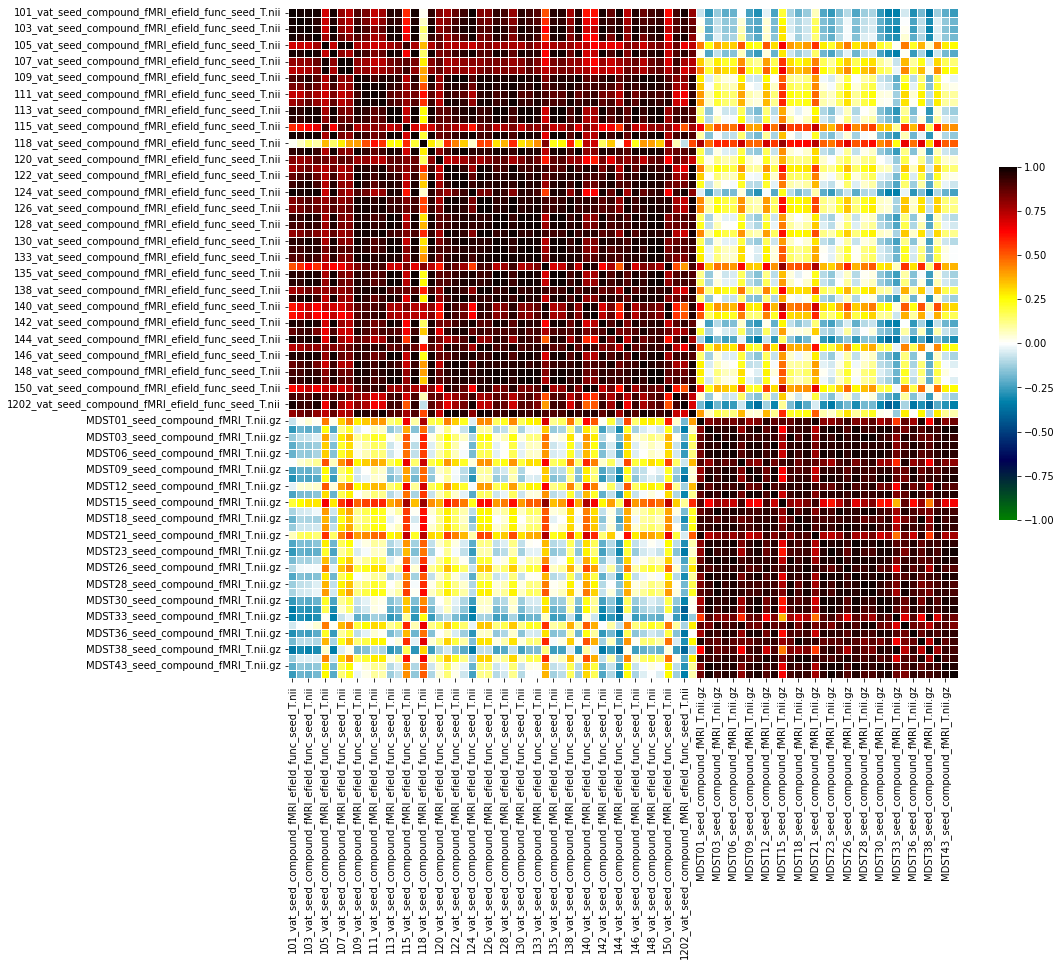

In [105]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)       
save_correlation_results(corr_df=corr_df, fig=fig, out_dir=out_dir, save=True, method_choice=method_choice)   

**Show Specific Heatmap**

In [19]:
print(corr_df.columns)

Index(['MDST43_seed_compound_fMRI_T.nii.gz',
       'MDST04_seed_compound_fMRI_T.nii.gz',
       'MDST12_seed_compound_fMRI_T.nii.gz',
       'MDST01_seed_compound_fMRI_T.nii.gz',
       'MDST28_seed_compound_fMRI_T.nii.gz',
       'MDST17_seed_compound_fMRI_T.nii.gz',
       'MDST18_seed_compound_fMRI_T.nii.gz',
       'MDST31_seed_compound_fMRI_T.nii.gz',
       'MDST27_seed_compound_fMRI_T.nii.gz',
       'MDST34_seed_compound_fMRI_T.nii.gz',
       'MDST22_seed_compound_fMRI_T.nii.gz',
       'MDST29_seed_compound_fMRI_T.nii.gz',
       'MDST23_seed_compound_fMRI_T.nii.gz',
       'MDST19_seed_compound_fMRI_T.nii.gz',
       'MDST30_seed_compound_fMRI_T.nii.gz',
       'MDST26_seed_compound_fMRI_T.nii.gz',
       'MDST33_seed_compound_fMRI_T.nii.gz',
       'MDST36_seed_compound_fMRI_T.nii.gz',
       'MDST09_seed_compound_fMRI_T.nii.gz',
       'MDST06_seed_compound_fMRI_T.nii.gz',
       'MDST39_seed_compound_fMRI_T.nii.gz',
       'MDST44_seed_compound_fMRI_T.nii.gz',
       'MD

In [75]:
#Enter networks of interest
network_of_interest = '150_vat_seed_compound_fMRI_efield_func_seed_T.nii'
networks_of_disinterest = [
    None   
]

#---isolate network of interest and remove those not of interest
corr_df_2 = corr_df.copy()
corr_df_2 = pd.DataFrame(corr_df_2.loc[:, network_of_interest])
if networks_of_disinterest[0] is not None:
    for network in networks_of_disinterest:
        corr_df_2.drop(network, inplace=True)
#Sort the dataframe by descending order
corr_df_2 = corr_df_2.sort_values(network_of_interest)
#Remove .nii from file names
for name in corr_df_2.columns.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='columns')
for name in corr_df_2.index.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='index')

#---Visualize the new data
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))

sns.heatmap(corr_df_2, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

#Save results
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.png')
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.svg')
corr_df_2.to_csv(out_dir + f'/spcorrel_{network_of_interest}.csv')
display(corr_df_2)
print(out_dir)

KeyError: '150_vat_seed_compound_fMRI_efield_func_seed_T.nii'

**Extract the Cross-Correlation Matrix**

In [18]:
def extract_cross_correlation_diagonal(corr_df):
    """
    Extracts the diagonal of the cross-correlation from the given correlation matrix.
    
    Parameters:
    - corr_df (DataFrame): The correlation matrix.
    
    Returns:
    - DataFrame: The diagonal of the cross-correlation with the patient identifiers as the index.
    
    Example usage:
    >>> cross_corr_diag = extract_cross_correlation_diagonal(corr_df)
    """
    
    # Assuming the dataframe is square and has an even number of columns,
    # split it into two equal parts
    n = len(corr_df)
    half_n = n // 2
    
    # Extract the values from the intersection of the rows of the first dataset 
    # and the columns of the second dataset
    cross_corr_values = [corr_df.iloc[i, i + half_n] for i in range(half_n)]
    
    # Convert to DataFrame while maintaining the index from the original corr_df
    cross_corr_df = pd.DataFrame(cross_corr_values, index=corr_df.index[:half_n], columns=["Cross-Correlation"])
    
    return cross_corr_df



In [19]:
cross_corr_diagonal_df = extract_cross_correlation_diagonal(corr_df)
cross_corr_diagonal_df

,Cross-Correlation
Somatomotor.nii,-0.061615
Memory Network.nii,0.569388
Default.nii,-0.816231
Ventral Attention.nii,-0.060248
Visual.nii,-0.511205
R-Map.nii,0.192406


<AxesSubplot: >

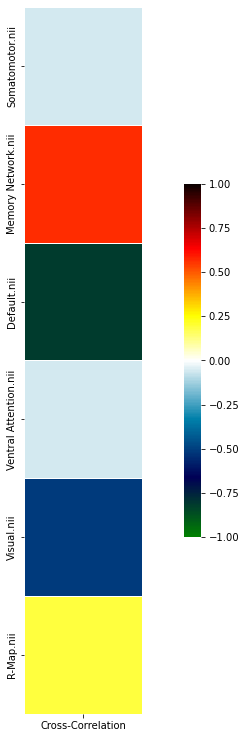

In [20]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(cross_corr_diagonal_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)       

Save Results

In [21]:
import os

def save_cross_correlation_results(corr_df, fig, out_dir, comparison, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    
    if save:
        out_dir = os.path.join(out_dir, comparison)
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_cross_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))

In [22]:
save_results = True

In [23]:
save_cross_correlation_results(corr_df=cross_corr_diagonal_df, fig=fig, out_dir=out_dir, comparison=comparison, save=save_results, method_choice=method_choice)

NameError: name 'comparison' is not defined

# 04 - Permute Spatial Correlation

In [ ]:
import pandas as pd
from tqdm import tqdm
from natsort import natsorted
import numpy as np

class PermutedSpatialCorrelation:
    def __init__(self, dataframe, n_permutations=1000):
        self.dataframe = dataframe
        self.n_permutations = n_permutations
        self.permuted_correlations = []
        self.observed_correlation = None

    def compute_correlation(self, df, method_choice=0, only_compare_nonzero_voxels=False):
        """
        Compute correlations among columns of a DataFrame using a specified method.
        When only_compare_nonzero_voxels is True, only pairs of non-zero voxels are used for the computation.
        
        Parameters:
        - df (DataFrame): The dataframe for which correlations should be computed.
        - method_choice (int, optional): An integer indicating the correlation method to be used. 
                                        0: Pearson (default), 1: Spearman, 2: Kendall.
        - only_compare_nonzero_voxels (bool, optional): Flag to determine whether to compute correlations 
                                                        considering only non-zero voxels. Default is False.
        
        Returns:
        - DataFrame: The correlation matrix.
        
        Example usage:
        >>> corr_matrix = compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=True)
        """
        
        methods = ['pearson', 'spearman', 'kendall']
        method = methods[method_choice]
        
        # If only_compare_nonzero_voxels is False, compute the correlation in the usual manner
        if not only_compare_nonzero_voxels:
            return df.corr(method=method), method
        else:
            columns = df.columns
            n = len(columns)
            
            # Initialize a dataframe to store the results
            corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
            
            # Iterate over each pair of columns
            for i in tqdm(range(n)):
                for j in range(i, n):
                    # Filter rows where both columns have non-zero values
                    temp_df = df[(df[columns[i]] != 0) & (df[columns[j]] != 0)]
                    
                    # Compute correlation for the filtered rows
                    corr_value = temp_df[[columns[i], columns[j]]].corr(method=method).iloc[0, 1]
                    
                    # Assign the computed value to the result dataframe
                    corr_df.iloc[i, j] = corr_value
                    corr_df.iloc[j, i] = corr_value
                    
        #Sort the Dataframe            
        corr_df = corr_df.reindex(index=natsorted(corr_df.index))
        corr_df = corr_df.reindex(columns=natsorted(corr_df.columns))
        return corr_df, method


    def permute_column(self, column):
        return np.random.permutation(column)

    def permute_and_correlate(self):
        permuted_df = self.dataframe.copy()
        for col in permuted_df.columns:
            permuted_df[col] = self.permute_column(permuted_df[col])
        permuted_corr, _ = self.compute_correlation(permuted_df)
        return permuted_corr

    def run_permutations(self):
        self.observed_correlation, _ = self.compute_correlation(self.dataframe)
        for _ in tqdm(range(self.n_permutations)):
            permuted_corr = self.permute_and_correlate()
            self.permuted_correlations.append(permuted_corr)

    def compute_p_value(self):
        if self.observed_correlation is None:
            raise ValueError("Run permutations first to compute observed correlation.")
        p_values = pd.DataFrame(index=self.dataframe.columns, columns=self.dataframe.columns)
        for i, col_i in enumerate(self.dataframe.columns):
            for j, col_j in enumerate(self.dataframe.columns):
                bool_array = [permuted_corr.iloc[i, j] > self.observed_correlation.iloc[i, j]
                              for permuted_corr in self.permuted_correlations]
                p_values.iloc[i, j] = np.mean(bool_array)
        return p_values

    def run(self):
        self.run_permutations()
        p_values = self.compute_p_value()
        return p_values, self.observed_correlation

# Usage:
# Create an instance of the class
# psc = PermutedSpatialCorrelation(dataframe, n_permutations=1000)
# p_values, observed_corr = psc.run()

In [ ]:
psc = PermutedSpatialCorrelation(masked_df, n_permutations=10000)
p_values, observed_corr = psc.run()
p_values

# Compute Agreement

In [58]:
def compute_agreement(df, method_choice='dice'):
    """
    Compute agreement among columns of a DataFrame using a specified method.
    
    Parameters:
    - df (DataFrame): The dataframe for which agreement should be computed.
    - method_choice (str, optional): A string indicating the agreement method to be used. 
                                     'dice': Dice Coefficient, 'jaccard': Jaccard Index, 'percent': % Agreement
    
    Returns:
    - Tuple(DataFrame, DataFrame, DataFrame): Positive agreement matrix, Negative agreement matrix, Overall agreement matrix.
    """
    
    columns = df.columns
    n = len(columns)
    
    # Initialize dataframes to store the results
    pos_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64') if method_choice != 'percent' else None
    neg_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64') if method_choice != 'percent' else None
    overall_corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
    
    # Binarize the DataFrame
    bin_df = df.applymap(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    # Iterate over each pair of columns
    for i in range(n):
        for j in range(i, n):
            
            col1, col2 = columns[i], columns[j]
            
            # Indices where both columns have the same sign (either both positive or both negative)
            same_sign = (bin_df[col1] == bin_df[col2]) & (bin_df[col1] != 0)
            
            # Indices where both columns are positive, negative, or any
            both_pos = (bin_df[col1] == 1) & (bin_df[col2] == 1)
            both_neg = (bin_df[col1] == -1) & (bin_df[col2] == -1)
            
            if method_choice == 'dice':
                # Dice Coefficient
                pos_value = 2 * both_pos.sum() / (bin_df[col1].eq(1).sum() + bin_df[col2].eq(1).sum())
                neg_value = 2 * both_neg.sum() / (bin_df[col1].eq(-1).sum() + bin_df[col2].eq(-1).sum())
                
            elif method_choice == 'jaccard':
                # Jaccard Index
                pos_value = both_pos.sum() / ((bin_df[col1] == 1) | (bin_df[col2] == 1)).sum()
                neg_value = both_neg.sum() / ((bin_df[col1] == -1) | (bin_df[col2] == -1)).sum()
                
            elif method_choice == 'percent':
                # % Agreement of voxels sharing the same sign
                overall_value = same_sign.sum() / len(bin_df)
                overall_corr_df.loc[col1, col2] = overall_value
                overall_corr_df.loc[col2, col1] = overall_value
                continue
            
            overall_value = (pos_value + neg_value) / 2
            
            # Update DataFrames
            if pos_corr_df is not None:
                pos_corr_df.loc[col1, col2] = pos_value
                pos_corr_df.loc[col2, col1] = pos_value
            if neg_corr_df is not None:
                neg_corr_df.loc[col1, col2] = neg_value
                neg_corr_df.loc[col2, col1] = neg_value
            overall_corr_df.loc[col1, col2] = overall_value
            overall_corr_df.loc[col2, col1] = overall_value
    
    return pos_corr_df, neg_corr_df, overall_corr_df


Agreement Methods
method  = 'jaccard', 'dice', or 'percent'

In [68]:
pos_corr_df, neg_corr_df, overall_corr_df = compute_agreement(masked_df, 'dice')

Positive Agreement

In [69]:
display(pos_corr_df)

,Cognitive Decline Network.nii,Default.nii,Dorsal Attention.nii,Frontoparietal.nii,Lesions Causing Amnesia.nii,Limbic.nii,Memory Network T Conn.nii,Memory Network.nii,R-Map.nii,Somatomotor.nii,Ventral Attention.nii,Visual.nii,generated_nifti.nii
Cognitive Decline Network.nii,1.000000,0.867574,0.141232,0.563445,0.696011,0.690165,0.772522,0.624015,0.633240,0.124596,0.177563,0.126254,0.455350
Default.nii,0.867574,1.000000,0.094239,0.546431,0.698737,0.663016,0.716648,0.570573,0.592105,0.141302,0.165567,0.070605,0.419491
Dorsal Attention.nii,0.141232,0.094239,1.000000,0.428888,0.290023,0.149824,0.214801,0.283789,0.373342,0.558235,0.660039,0.677776,0.458502
Frontoparietal.nii,0.563445,0.546431,0.428888,1.000000,0.417996,0.281044,0.420758,0.375631,0.709148,0.161426,0.431751,0.172823,0.493819
Lesions Causing Amnesia.nii,0.696011,0.698737,0.290023,0.417996,1.000000,0.586289,0.760170,0.663768,0.450803,0.193771,0.157110,0.365907,0.395099
Limbic.nii,0.690165,0.663016,0.149824,0.281044,0.586289,1.000000,0.582939,0.492113,0.393471,0.346174,0.264615,0.142411,0.431589
Memory Network T Conn.nii,0.772522,0.716648,0.214801,0.420758,0.760170,0.582939,1.000000,0.823675,0.565535,0.186782,0.217006,0.338820,0.448071
Memory Network.nii,0.624015,0.570573,0.283789,0.375631,0.663768,0.492113,0.823675,1.000000,0.550784,0.269222,0.316572,0.391925,0.449710
R-Map.nii,0.633240,0.592105,0.373342,0.709148,0.450803,0.393471,0.565535,0.550784,1.000000,0.308361,0.499222,0.215153,0.579811
Somatomotor.nii,0.124596,0.141302,0.558235,0.161426,0.193771,0.346174,0.186782,0.269222,0.308361,1.000000,0.743071,0.454454,0.435580


<AxesSubplot: >

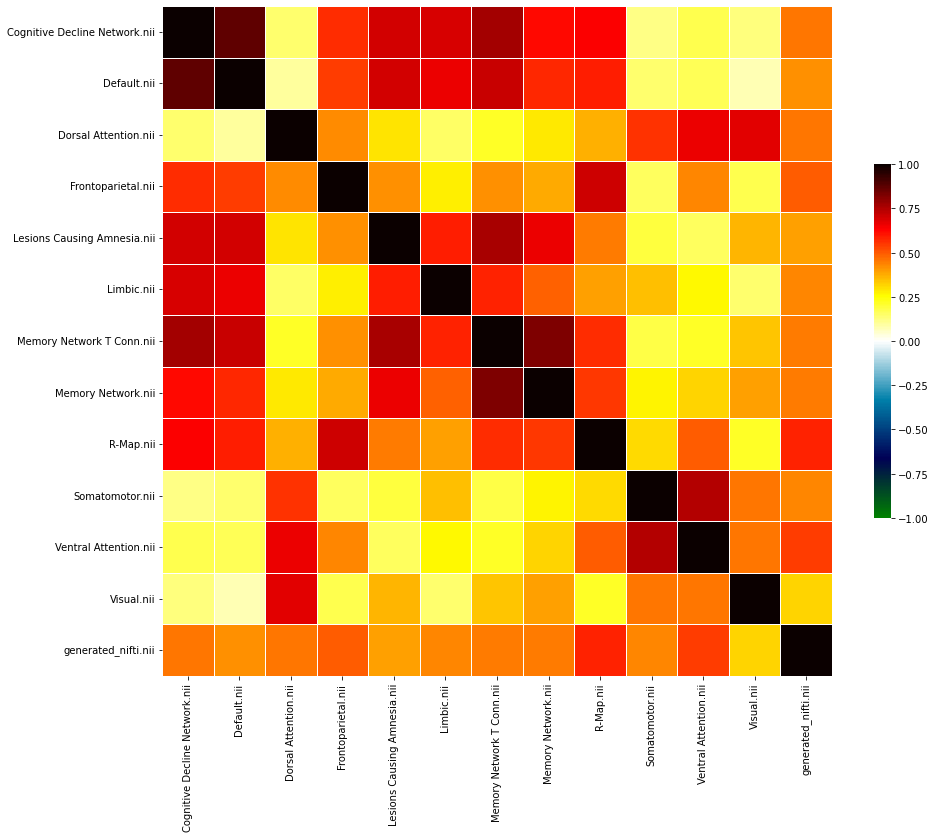

In [70]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(pos_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

Negative Agreement

In [71]:
display(neg_corr_df)

,Cognitive Decline Network.nii,Default.nii,Dorsal Attention.nii,Frontoparietal.nii,Lesions Causing Amnesia.nii,Limbic.nii,Memory Network T Conn.nii,Memory Network.nii,R-Map.nii,Somatomotor.nii,Ventral Attention.nii,Visual.nii,generated_nifti.nii
Cognitive Decline Network.nii,1.000000,0.896941,0.266961,0.661413,0.750026,0.760686,0.797994,0.686851,0.639559,0.320844,0.203977,0.409895,0.522797
Default.nii,0.896941,1.000000,0.329777,0.695635,0.785267,0.774823,0.781746,0.690088,0.651776,0.423600,0.298841,0.459104,0.557230
Dorsal Attention.nii,0.266961,0.329777,1.000000,0.578853,0.443451,0.375669,0.336568,0.432598,0.413566,0.674138,0.686860,0.793342,0.545681
Frontoparietal.nii,0.661413,0.695635,0.578853,1.000000,0.585875,0.521263,0.555357,0.550953,0.752052,0.439073,0.524125,0.520330,0.614931
Lesions Causing Amnesia.nii,0.750026,0.785267,0.443451,0.585875,1.000000,0.707366,0.804895,0.743328,0.504244,0.426133,0.250211,0.607965,0.513132
Limbic.nii,0.760686,0.774823,0.375669,0.521263,0.707366,1.000000,0.681172,0.636249,0.486442,0.564498,0.386676,0.504865,0.571438
Memory Network T Conn.nii,0.797994,0.781746,0.336568,0.555357,0.804895,0.681172,1.000000,0.854638,0.577347,0.375563,0.249804,0.558142,0.520333
Memory Network.nii,0.686851,0.690088,0.432598,0.550953,0.743328,0.636249,0.854638,1.000000,0.589938,0.474265,0.385695,0.619903,0.550991
R-Map.nii,0.639559,0.651776,0.413566,0.752052,0.504244,0.486442,0.577347,0.589938,1.000000,0.411334,0.468644,0.417482,0.593908
Somatomotor.nii,0.320844,0.423600,0.674138,0.439073,0.426133,0.564498,0.375563,0.474265,0.411334,1.000000,0.784774,0.683545,0.569567


<AxesSubplot: >

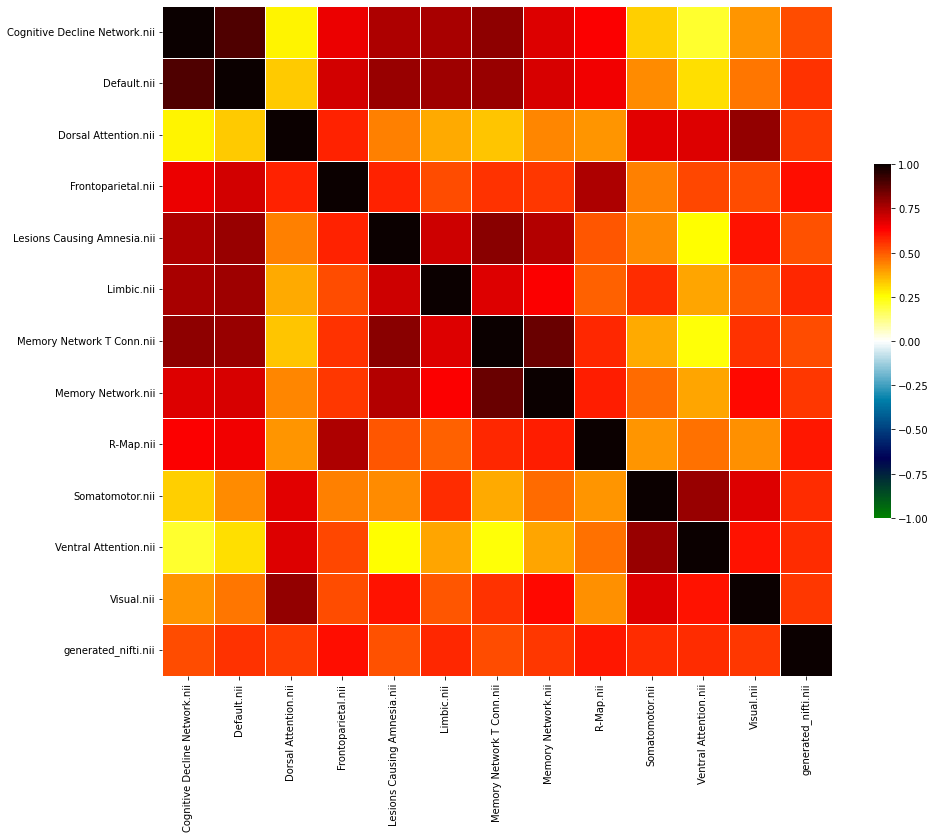

In [72]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(neg_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

Overall Agreement

In [73]:
display(overall_corr_df)

,Cognitive Decline Network.nii,Default.nii,Dorsal Attention.nii,Frontoparietal.nii,Lesions Causing Amnesia.nii,Limbic.nii,Memory Network T Conn.nii,Memory Network.nii,R-Map.nii,Somatomotor.nii,Ventral Attention.nii,Visual.nii,generated_nifti.nii
Cognitive Decline Network.nii,1.000000,0.882258,0.204096,0.612429,0.723018,0.725426,0.785258,0.655433,0.636400,0.222720,0.190770,0.268074,0.489073
Default.nii,0.882258,1.000000,0.212008,0.621033,0.742002,0.718920,0.749197,0.630330,0.621941,0.282451,0.232204,0.264854,0.488361
Dorsal Attention.nii,0.204096,0.212008,1.000000,0.503870,0.366737,0.262746,0.275685,0.358194,0.393454,0.616186,0.673450,0.735559,0.502091
Frontoparietal.nii,0.612429,0.621033,0.503870,1.000000,0.501936,0.401154,0.488057,0.463292,0.730600,0.300250,0.477938,0.346577,0.554375
Lesions Causing Amnesia.nii,0.723018,0.742002,0.366737,0.501936,1.000000,0.646827,0.782532,0.703548,0.477523,0.309952,0.203660,0.486936,0.454116
Limbic.nii,0.725426,0.718920,0.262746,0.401154,0.646827,1.000000,0.632056,0.564181,0.439956,0.455336,0.325645,0.323638,0.501513
Memory Network T Conn.nii,0.785258,0.749197,0.275685,0.488057,0.782532,0.632056,1.000000,0.839157,0.571441,0.281173,0.233405,0.448481,0.484202
Memory Network.nii,0.655433,0.630330,0.358194,0.463292,0.703548,0.564181,0.839157,1.000000,0.570361,0.371743,0.351133,0.505914,0.500350
R-Map.nii,0.636400,0.621941,0.393454,0.730600,0.477523,0.439956,0.571441,0.570361,1.000000,0.359847,0.483933,0.316317,0.586860
Somatomotor.nii,0.222720,0.282451,0.616186,0.300250,0.309952,0.455336,0.281173,0.371743,0.359847,1.000000,0.763922,0.568999,0.502573


<AxesSubplot: >

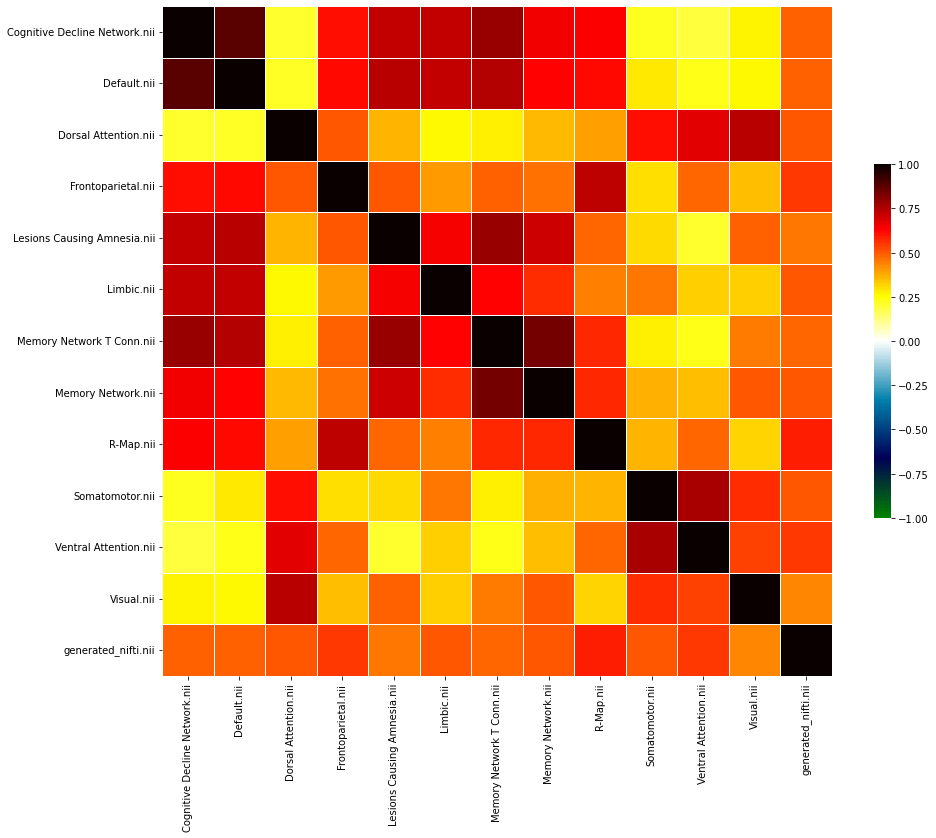

In [74]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(overall_corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)    

# Specific Sub-Analyses

In [56]:
merged_df.columns

Index(['Somatomotor.nii', 'Memory Network.nii', 'Default.nii',
       'Ventral Attention.nii', 'Visual.nii', 'R-Map.nii', 'Limbic.nii',
       'Lesions Causing Amnesia.nii', 'Dorsal Attention.nii',
       'Frontoparietal.nii', 'Cognitive Decline Network.nii',
       'Memory Network T Conn.nii', 'generated_nifti.nii'],
      dtype='object')

In [61]:
from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(masked_df['Memory Network.nii'], masked_df['R-Map.nii'])
# Format p-value to display more decimal places
formatted_p = "{:.10f}".format(p)

print("Correlation coefficient (r):", r)
print("Formatted p-value:", formatted_p)

Correlation coefficient (r): 0.05812207571888118
Formatted p-value: 0.0000000000


Run Mantel Test
- Struggles on vectors >15 000 length. 

In [10]:
vec_1 = 'Cognitive Decline Network.nii'
vec_2 = 'R-Map.nii'

In [13]:
import numpy as np
from skbio.stats.distance import mantel
from scipy.spatial.distance import pdist, squareform

# Assuming masked_df is your DataFrame and vec_1, vec_2 are column names
vector1 = masked_df[vec_1].to_numpy()
# vector2 = masked_df[vec_2].to_numpy()

# # Convert vectors to distance matrices
distance_matrix_1 = squareform(pdist(vector1.reshape(-1, 1), 'euclidean'))
# distance_matrix_2 = squareform(pdist(vector2.reshape(-1, 1), 'euclidean'))

# # Perform the Mantel test on the distance matrices
# correlation, p_value, _ = mantel(distance_matrix_1, distance_matrix_2, method='pearson', permutations=999)

# print("Correlation:", correlation)
# print("P-value:", p_value)

: 

In [12]:
vector1

array([0.57003174, 0.53607564, 0.47637063, ..., 0.62729602, 0.61700541,
       0.61567389])